In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from utils import script

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Epochs = 18
B_SIZE = 256
classes = ["T-shirt/top",
"Trouser",
"Pullover",
"Dress",
"Coat",
"Sandal",
"Shirt",
"Sneaker",
"Bag",
"Ankle boot"] 

In [3]:
# Dataset
t = transforms.Compose([transforms.ToTensor()
                       ])
target_t = lambda label: F.one_hot(torch.tensor(label), num_classes=10).type(torch.float32)


train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=t, target_transform=target_t, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=t, target_transform=target_t, download=True)

train_loader = DataLoader(train_dataset, batch_size=B_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=B_SIZE, shuffle=False, num_workers=4, pin_memory=True)

Visualizig image in dataset


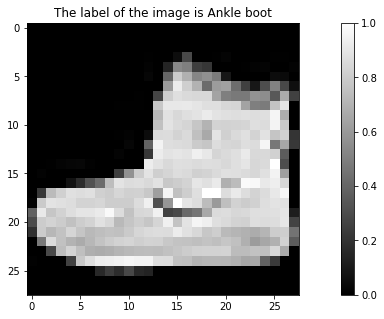

In [4]:
# img = next(iter(test_loader))[0][0].permute(1,2,0)
img = train_dataset[0][0].permute(1,2,0)
label = next(iter(test_loader))[1][0].argmax()

def visual(img, label):
    print("Visualizig image in dataset")

    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    img = img.numpy()
    im = ax.imshow(img, cmap="gray")

    fig.colorbar(im)
    ax.set_title(f"The label of the image is {label}")
    
visual(img, classes[label])

In [5]:
class torch_LSTM(nn.Module):
    def __init__(self, input_dims, emd_dim, hidden_dim, num_layers, mode):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.mode = mode
        
        self.encoder = nn.Linear(in_features=input_dims, out_features=emd_dim)
        self.lstm = nn.LSTM(input_size=emd_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)
        return
    
    
    def forward(self, x):
        b_size, n_channels, n_rows, n_cols = x.shape
        h,c = self.init_state(b_size=b_size, device=x.device)
        
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)
        embeddings = self.encoder(x_rowed)
        
        lstm_out , (h_out, c_out) = self.lstm(embeddings, (h,c))
        
        y = self.classifier(lstm_out[:, -1, :])
        
        return y
    
    def init_state(self, b_size, device):
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "learned"):
            h = self.learned_h.repeat(1, b_size, 1)
            c = self.learned_c.repeat(1, b_size, 1)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [6]:
model = torch_LSTM(input_dims=28, emd_dim=64, hidden_dim=128, num_layers=2, mode="zeros")

In [7]:
model

torch_LSTM(
  (encoder): Linear(in_features=28, out_features=64, bias=True)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [10]:
# train_loss, val_loss, loss_iters, valid_acc = script.train_model(
#         model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
#         train_loader=train_loader, valid_loader=test_loader, num_epochs=10, device="cpu"
#     )

In [8]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()
        self.encoder = nn.Linear(in_features=28, out_features=64)
        self.classifier = nn.Linear(in_features=128, out_features=10)
        
        
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
            
    def lstm_forward(self, x, init_states=None):
        
        bs, channel , seq_sz, input_dim = x.size()
        x = x.view(bs, channel*seq_sz, input_dim)
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
            
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)
    
    def forward(self, x):
        x = self.encoder(x)
        hidden_seq, _ = self.lstm_forward(x)
        y = self.classifier(hidden_seq[:, -1, :])
        return y

In [9]:
model1 = CustomLSTM(input_sz=64, hidden_sz=128)

In [10]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model1.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [11]:
train_loss, val_loss, loss_iters, valid_acc = script.train_model(
        model=model1, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10, device="cpu"
    )

Epoch 1 Iter 235: loss 0.63669. : 100%|███████| 235/235 [00:15<00:00, 15.16it/s]

Epoch 1/10
    Train loss: 1.23415
    Valid loss: 2.30192
    Accuracy: 12.33%





Epoch 2 Iter 235: loss 0.48048. : 100%|███████| 235/235 [00:15<00:00, 15.00it/s]

Epoch 2/10
    Train loss: 0.60442
    Valid loss: 0.68304
    Accuracy: 75.29%





Epoch 3 Iter 235: loss 0.37395. : 100%|███████| 235/235 [00:15<00:00, 14.90it/s]

Epoch 3/10
    Train loss: 0.52773
    Valid loss: 0.56155
    Accuracy: 79.14999999999999%





Epoch 4 Iter 235: loss 0.50154. : 100%|███████| 235/235 [00:15<00:00, 14.78it/s]

Epoch 4/10
    Train loss: 0.48001
    Valid loss: 0.5143
    Accuracy: 81.04%





Epoch 5 Iter 235: loss 0.40909. : 100%|███████| 235/235 [00:15<00:00, 15.23it/s]

Epoch 5/10
    Train loss: 0.44947
    Valid loss: 0.47653
    Accuracy: 82.75%





Epoch 6 Iter 235: loss 0.37694. : 100%|███████| 235/235 [00:15<00:00, 14.77it/s]

Epoch 6/10
    Train loss: 0.41477
    Valid loss: 0.4576
    Accuracy: 83.15%





Epoch 7 Iter 235: loss 0.43427. : 100%|███████| 235/235 [00:15<00:00, 14.69it/s]

Epoch 7/10
    Train loss: 0.40726
    Valid loss: 0.43978
    Accuracy: 83.95%





Epoch 8 Iter 235: loss 0.37857. : 100%|███████| 235/235 [00:16<00:00, 14.39it/s]

Epoch 8/10
    Train loss: 0.40247
    Valid loss: 0.43255
    Accuracy: 84.21%





Epoch 9 Iter 235: loss 0.46355. : 100%|███████| 235/235 [00:16<00:00, 14.36it/s]

Epoch 9/10
    Train loss: 0.39856
    Valid loss: 0.4298
    Accuracy: 84.36%





Epoch 10 Iter 235: loss 0.36235. : 100%|██████| 235/235 [00:16<00:00, 14.00it/s]

Epoch 10/10
    Train loss: 0.39336
    Valid loss: 0.42673
    Accuracy: 84.28%


Training completed
